In [1]:
# Imports math library
import numpy as np
# Imports plotting library
import matplotlib.pyplot as plt
# Import math Library
import math

import jax.numpy as jnp
import jax
from jax import jit
from jax.typing import ArrayLike

In [2]:
# Define the Rectified Linear Unit (ReLU) function
def ReLU(preactivation:ArrayLike)->ArrayLike:
  activation = preactivation.clip(0.0)
  return activation

# Define a shallow neural network
def shallow_nn(x, beta_0, omega_0, beta_1, omaga_1):
    # Make sure that input data is (1 x n_data) array
    n_data = x.size
    x = jnp.reshape(x,(1,n_data))

    # This runs the network for ALL of the inputs, x at once so we can draw graph
    h1 = ReLU(jnp.matmul(beta_0,jnp.ones((1,n_data))) + jnp.matmul(omega_0,x))
    model_out = jnp.matmul(beta_1,jnp.ones((1,n_data))) + jnp.matmul(omega_1,h1)
    return model_out

In [3]:
# Get parameters for model -- we can call this function to easily reset them
@jit
def get_parameters():
  # And we'll create a network that approximately fits it
  beta_0 = jnp.zeros((3,1));  # formerly theta_x0
  omega_0 = jnp.zeros((3,1)); # formerly theta_x1
  beta_1 = jnp.zeros((1,1));  # formerly phi_0
  omega_1 = jnp.zeros((1,3)); # formerly phi_x

  beta_0=beta_0.at[0,0].set(0.3);
  beta_0=beta_0.at[1,0].set(-1.0);
  beta_0=beta_0.at[2,0].set(-0.5);
  omega_0=omega_0.at[0,0].set(-1.0);
  omega_0=omega_0.at[1,0].set(1.8);
  omega_0=omega_0.at[2,0].set(0.65)
  beta_1=beta_1.at[0,0].set(2.6);
  omega_1=omega_1.at[0,0].set(-24.0);
  omega_1=omega_1.at[0,1].set(-8.0);
  omega_1=omega_1.at[0,2].set(50.0)

  return beta_0, omega_0, beta_1, omega_1

In [4]:
# Utility function for plotting data
def plot_binary_classification(x_model, out_model, lambda_model, x_data = None, y_data = None, title= None):
  # Make sure model data are 1D arrays
  x_model = jnp.squeeze(x_model)
  out_model = jnp.squeeze(out_model)
  lambda_model = jnp.squeeze(lambda_model)

  fig, ax = plt.subplots(1,2)
  fig.set_size_inches(7.0, 3.5)
  fig.tight_layout(pad=3.0)
  ax[0].plot(x_model,out_model)
  ax[0].set_xlabel('Input, $x$'); ax[0].set_ylabel('Model output')
  ax[0].set_xlim([0,1]);ax[0].set_ylim([-4,4])
  if title is not None:
    ax[0].set_title(title)
  ax[1].plot(x_model,lambda_model)
  ax[1].set_xlabel('Input, $x$'); ax[1].set_ylabel('$\lambda$ or Pr(y=1|x)')
  ax[1].set_xlim([0,1]);ax[1].set_ylim([-0.05,1.05])
  if title is not None:
    ax[1].set_title(title)
  if x_data is not None:
    ax[1].plot(x_data, y_data, 'ko')
  plt.show()

In [5]:
# Sigmoid function that maps [-infty,infty] to [0,1]
def sigmoid(model_out:ArrayLike)->float:
  # TODO -- implement the logistic sigmoid function from equation 5.18
  # Replace this line:
  sig_model_out = 1/(1+jnp.exp(-model_out))

  return sig_model_out

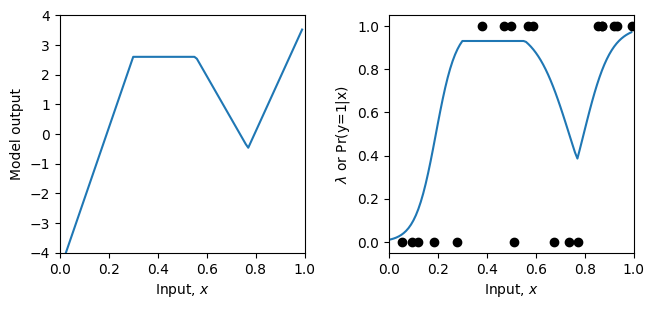

In [6]:
x_train = jnp.array([0.09291784,0.46809093,0.93089486,0.67612654,0.73441752,0.86847339,\
                   0.49873225,0.51083168,0.18343972,0.99380898,0.27840809,0.38028817,\
                   0.12055708,0.56715537,0.92005746,0.77072270,0.85278176,0.05315950,\
                   0.87168699,0.58858043])
y_train = jnp.array([0,1,1,0,0,1,\
                    1,0,0,1,0,1,\
                    0,1,1,0,1,0, \
                    1,1])

# Get parameters for the model
beta_0, omega_0, beta_1, omega_1 = get_parameters()

# Define a range of input values
x_model = jnp.arange(0,1,0.01)
# Run the model to get values to plot and plot it.
model_out= shallow_nn(x_model, beta_0, omega_0, beta_1, omega_1)
lambda_model = sigmoid(model_out)
plot_binary_classification(x_model, model_out, lambda_model, x_train, y_train)


In [7]:
# Return probability under Bernoulli distribution for input x
def bernoulli_distribution(y:ArrayLike, lambda_param:float)->ArrayLike:
    # TODO-- write in the equation for the Bernoulli distribution
    # Equation 5.17 from the notes (you will need np.power)
    # Replace the line below
    prob = jnp.power((1-lambda_param),1-y) *jnp.power(lambda_param,y)

    return prob

In [8]:
# Let's double check we get the right answer before proceeding
print("Correct answer = %3.3f, Your answer = %3.3f"%(0.8,bernoulli_distribution(0,0.2)))
print("Correct answer = %3.3f, Your answer = %3.3f"%(0.2,bernoulli_distribution(1,0.2)))

Correct answer = 0.800, Your answer = 0.800
Correct answer = 0.200, Your answer = 0.200


In [9]:
# Return the likelihood of all of the data under the model
def compute_likelihood(y_train, lambda_param):
  # TODO -- compute the likelihood of the data -- the product of the Bernoulli probabilities for each data point
  # Top line of equation 5.3 in the notes
  # You will need np.prod() and the bernoulli_distribution function you used above
  # Replace the line below
  likelihood = jnp.prod(bernoulli_distribution(y_train,lambda_param))

  return likelihood

In [10]:
# Let's test this
beta_0, omega_0, beta_1, omega_1 = get_parameters()
# Use our neural network to predict the mean of the Gaussian
model_out = shallow_nn(x_train, beta_0, omega_0, beta_1, omega_1)
lambda_train = sigmoid(model_out)
# Compute the likelihood
likelihood = compute_likelihood(y_train, lambda_train)
# Let's double check we get the right answer before proceeding
print("Correct answer = %9.9f, Your answer = %9.9f"%(0.000070237,likelihood))

Correct answer = 0.000070237, Your answer = 0.000070237


In [12]:
# Return the negative log likelihood of the data under the model
def compute_negative_log_likelihood(y_train, lambda_param):
  # TODO -- compute the likelihood of the data -- don't use the likelihood function above -- compute the negative sum of the log probabilities
  # You will need np.sum(), np.log()
  # Replace the line below
  nll = -jnp.sum(jnp.log(bernoulli_distribution(y_train,lambda_param)))

  return nll

In [13]:
# Let's test this
beta_0, omega_0, beta_1, omega_1 = get_parameters()
# Use our neural network to predict the mean of the Gaussian
model_out = shallow_nn(x_train, beta_0, omega_0, beta_1, omega_1)
# Pass through the sigmoid function
lambda_train = sigmoid(model_out)
# Compute the log likelihood
nll = compute_negative_log_likelihood(y_train, lambda_train)
# Let's double check we get the right answer before proceeding
print("Correct answer = %9.9f, Your answer = %9.9f"%(9.563639387,nll))

Correct answer = 9.563639387, Your answer = 9.563638687


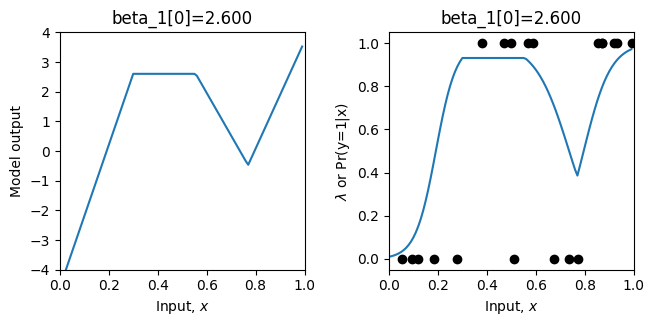

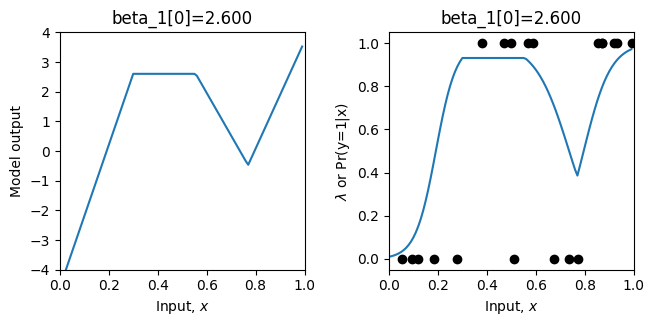

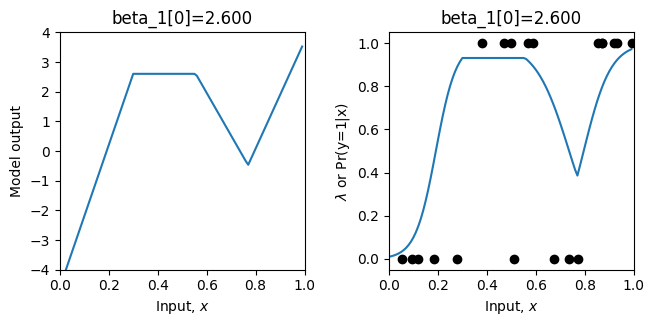

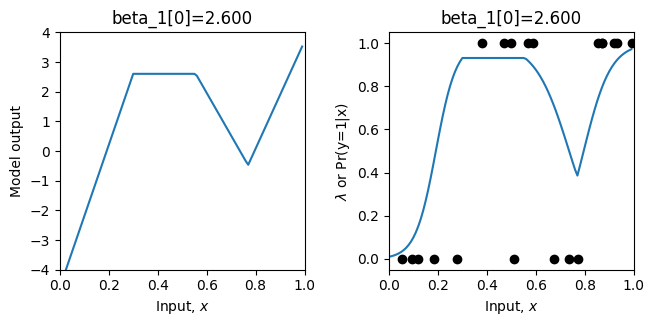

In [14]:
# Define a range of values for the parameter
beta_1_vals = jnp.arange(-2,6.0,0.1)
# Create some arrays to store the likelihoods, negative log likelihoodslit function
likelihoods = jnp.zeros_like(beta_1_vals)
nlls = jnp.zeros_like(beta_1_vals)

# Initialise the parameters
beta_0, omega_0, beta_1, omega_1 = get_parameters()
for count in range(len(beta_1_vals)):
  # Set the value for the parameter
  beta_1.at[0,0].set(beta_1_vals[count])
  # Run the network with new parameters
  model_out = shallow_nn(x_train, beta_0, omega_0, beta_1, omega_1)
  lambda_train = sigmoid(model_out)
  # Compute and store the three values
  likelihoods.at[count].set(compute_likelihood(y_train,lambda_train))
  nlls.at[count].set(compute_negative_log_likelihood(y_train, lambda_train))
  # Draw the model for every 20th parameter setting
  if count % 20 == 0:
    # Run the model to get values to plot and plot it.
    model_out = shallow_nn(x_model, beta_0, omega_0, beta_1, omega_1)
    lambda_model = sigmoid(model_out)
    plot_binary_classification(x_model, model_out, lambda_model, x_train, y_train, title="beta_1[0]=%3.3f"%(beta_1[0,0]))


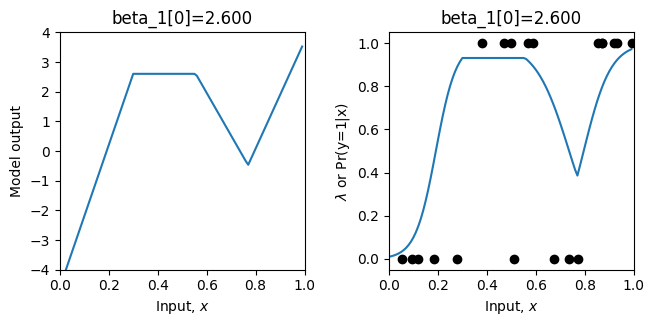

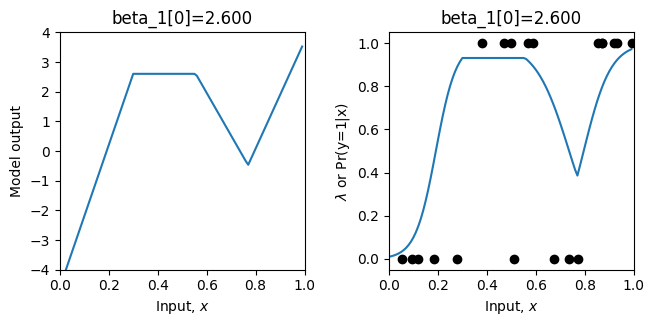

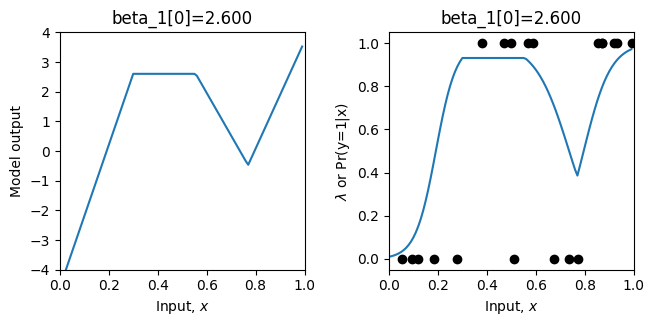

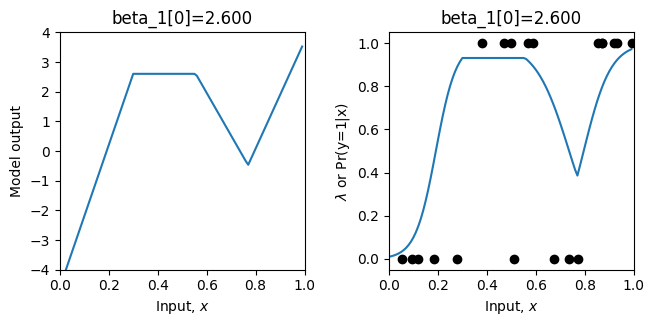

In [15]:
# Define a range of values for the parameter
beta_1_vals = jnp.arange(-2,6.0,0.1)
# Create some arrays to store the likelihoods, negative log likelihoods
likelihoods = jnp.zeros_like(beta_1_vals)
nlls = jnp.zeros_like(beta_1_vals)

# Initialise the parameters
beta_0, omega_0, beta_1, omega_1 = get_parameters()
for count in range(len(beta_1_vals)):
  # Set the value for the parameter
  beta_1.at[0,0].set(beta_1_vals[count])
  # Run the network with new parameters
  model_out = shallow_nn(x_train, beta_0, omega_0, beta_1, omega_1)
  lambda_train = sigmoid(model_out)
  # Compute and store the three values
  likelihoods.at[count].set(compute_likelihood(y_train,lambda_train))
  nlls.at[count].set(compute_negative_log_likelihood(y_train, lambda_train))
  # Draw the model for every 20th parameter setting
  if count % 20 == 0:
    # Run the model to get values to plot and plot it.
    model_out = shallow_nn(x_model, beta_0, omega_0, beta_1, omega_1)
    lambda_model = sigmoid(model_out)
    plot_binary_classification(x_model, model_out, lambda_model, x_train, y_train, title="beta_1[0]=%3.3f"%(beta_1[0,0]))


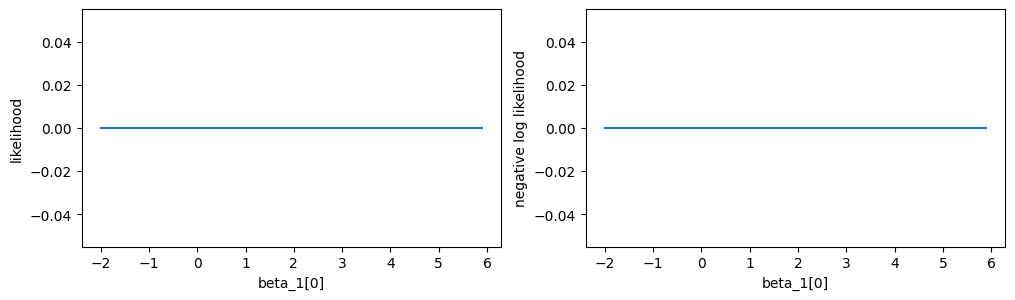

In [16]:
# Now let's plot the likelihood, and negative log likelihoods as a function the value of the offset beta1
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10.5, 3.5)
fig.tight_layout(pad=3.0)
ax[0].plot(beta_1_vals, likelihoods); ax[0].set_xlabel('beta_1[0]'); ax[0].set_ylabel('likelihood')
ax[1].plot(beta_1_vals, nlls); ax[1].set_xlabel('beta_1[0]'); ax[1].set_ylabel('negative log likelihood')
plt.show()

Maximum likelihood = 0.000000, at beta_1=-2.000
Minimum negative log likelihood = 0.000000, at beta_1=-2.000


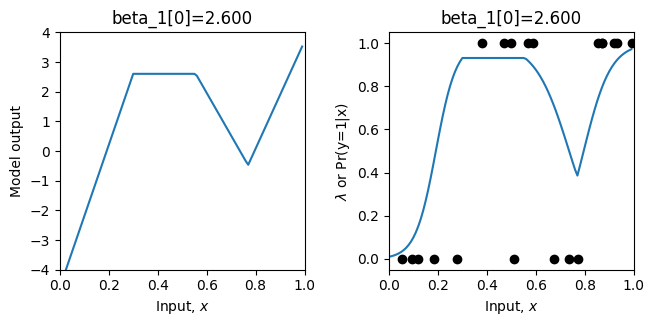

In [18]:
# Hopefully, you can see that the maximum of the likelihood fn is at the same position as the minimum negative log likelihood
# Let's check that:
print("Maximum likelihood = %f, at beta_1=%3.3f"%( (likelihoods[jnp.argmax(likelihoods)],beta_1_vals[jnp.argmax(likelihoods)])))
print("Minimum negative log likelihood = %f, at beta_1=%3.3f"%( (nlls[jnp.argmin(nlls)],beta_1_vals[jnp.argmin(nlls)])))

# Plot the best model
beta_1.at[0,0].set(beta_1_vals[jnp.argmin(nlls)])
model_out = shallow_nn(x_model, beta_0, omega_0, beta_1, omega_1)
lambda_model = sigmoid(model_out)
plot_binary_classification(x_model, model_out, lambda_model, x_train, y_train, title="beta_1[0]=%3.3f"%(beta_1[0,0]))
